# Mercado Secundário de Títulos Públicos - AMBIMA

Nesta primeira parte, deixo função genéricas de download e carregamento dos dados do CSV

Página da AMBIMA: https://www.anbima.com.br/pt_br/informar/taxas-de-titulos-publicos.htm

In [1]:
import time
import requests
import numpy as np
import pandas as pd

def get_filename(t):
    """
        - t     : datetime.date
        returno : String com o nome do arquivo da AMBIMA
    """
    return 'ms%s.txt' % t.strftime("%y%m%d")

def download(t):
    """
        - t     : datetime.date
        returno : Inteiro com o código HTTP de retorno da aquisição

        Faz download do arquivo disponibilidado pela AMBIMA.
        Escreve o arquivo no diretório local.
        Usa o encoding padrão na escrita

        Referencias:
        'https://www.anbima.com.br/pt_br/informar/taxas-de-titulos-publicos.htm'
        'https://www.anbima.com.br/informacoes/merc-sec/arqs/ms240519.txt'
    """

    url = 'https://www.anbima.com.br/informacoes/merc-sec/arqs/'

    time.sleep(2)
    response = requests.get(url + get_filename(t))
    print(t, 'response', response.status_code)

    if response.status_code == 200:
        with open(get_filename(t), 'wb') as fp:
            fp.write(response.content)

    return response.status_code

def load_df(t):
    """
        - t     : datetime.date
        returno : pd.DataFrame com os dados dos títulos

        Lê o arquivo no diretório local.
        O arquivo deve estar presente, ou seja a função download deve ser chamada antes.
    """
    date_cols = ['Data Referencia', 'Data Base/Emissao', 'Data Vencimento']
    return pd.read_csv(get_filename(t), sep='@', decimal=',', skiprows=2,
            parse_dates=date_cols, engine='python', encoding='latin-1')

# Exemplo

Nesta segundo parte, faço um pequeno script para baixar os dados e apresentar em um gráfico.

Eu apresento este exemplo em vídeo: https://youtu.be/GHmyHzl4XPU

downloading...
2024-05-21 00:00:00 response 200
2024-05-22 00:00:00 response 200
2024-05-23 00:00:00 response 200
2024-05-24 00:00:00 response 200
2024-05-27 00:00:00 response 200
2024-05-28 00:00:00 response 200
   Data Vencimento  Tx. Compra  Tx. Venda
0       2024-07-01     10.3330    10.2982
1       2024-10-01     10.2752    10.2276
2       2025-01-01     10.2877    10.2513
3       2025-04-01     10.4400    10.4254
4       2025-07-01     10.5515    10.5364
5       2025-10-01     10.6582    10.6410
6       2026-01-01     10.7463    10.7351
7       2026-04-01     10.8662    10.8526
8       2026-07-01     10.9592    10.9475
9       2027-07-01     11.2280    11.2139
10      2028-01-01     11.3947    11.3843
11      2030-01-01     11.7520    11.7418
   Data Vencimento  Tx. Compra  Tx. Venda
0       2024-07-01     10.3394    10.3010
1       2024-10-01     10.2576    10.2061
2       2025-01-01     10.2770    10.2270
3       2025-04-01     10.3986    10.3844
4       2025-07-01     10.4922 

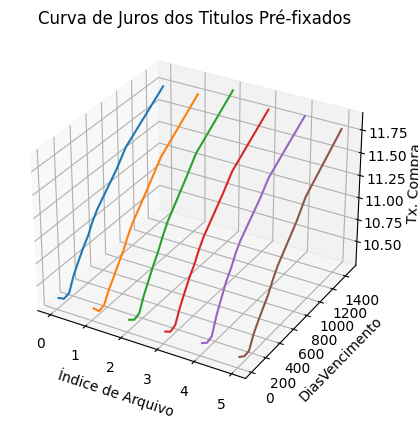

In [12]:
from pandas.tseries.offsets import BDay
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import *

def dias_p_vencimento(t, serie):
    """
        - t    : datetime.date
        - serie : pd.Series

        returno : np.array da mesma dimensão da serie.

        A função calcula quantos dias úteis existem entre dias datas.
        Não considerar o calendarios de feriados.
    """
    dt_array = np.array([t] * serie.shape[0]).astype('datetime64[D]')
    return np.busday_count(dt_array, serie.values.astype('datetime64[D]'))

def titulo_df(t, df, titulo):
    """
        - df     : pd.Dataframe, saída da função load_df(t)
        - titulo : sigla do título na AMBIMA ['LFT', 'LTN', 'NTN-B', 'NTN-C', 'NTN-F']
        returno : pd.DataFrame com as   plot3das do título selecionado
        Função espefícica para plotar o gráfico.
    """
    df_curva = df[df['Titulo'] == titulo][['Data Vencimento', 'Tx. Compra', 'Tx. Venda']]
    #print(df_curva)
    #taxa de juros para cada um
    #curva = df_curva.set_index('Data Vencimento')
    #curva.plot()
    #plt.show()
    df_curva['DiasVencimento'] = dias_p_vencimento(t, df_curva['Data Vencimento'])
    df_curva['Tx. Compra'] = df_curva['Tx. Compra'].replace('--', np.nan).astype(np.float64)
    df_curva['Tx. Venda'] = df_curva['Tx. Venda'].replace('--', np.nan).astype(np.float64)
    return df_curva

if __name__ == '__main__':
    """
        Configurar o range de datas.
        Segundo testes, a AMBIMA disponibiliza os arquivos durante apx ~7dias
    """

    # Datas que serão baixadas
    drange = pd.date_range(start='2024-05-21', end='2024-05-28', freq=BDay()).tolist()

    # Download e tratamento dos arquivos não-disponíveis
    print('downloading...')
    set404 = set([])
    for t in drange:
        r = download(t)
        if r != 200:
            set404.add(t)
    fileset = set(drange)- set404

    # Carregando DataFrames e Plotando 3D
    plot3d = plt.subplot(projection='3d')
    for i, t in enumerate(fileset):
        df = load_df(t)
        #Mudar sigla do titulo
        df = titulo_df(t, df, 'LTN')
        plot3d.plot([i]*len(df), df['DiasVencimento'], df['Tx. Compra'])

    # Configuração dos rótulos dos eixos
    plot3d.set_xlabel('Índice de Arquivo')
    plot3d.set_ylabel('DiasVencimento')
    plot3d.set_zlabel('Tx. Compra(Juros)')

    # Configuração do título
    plot3d.set_title('Curva de Juros dos Titulos Pré-fixados')

    # Ajuste da perspectiva
    #plot3d.view_init(elev=45, azim=45)  # Ajuste os valores conforme necessário

    plt.show()